In [1]:
!nvidia-smi

Sat Dec 19 15:51:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
| 61%   72C    P0    80W / 280W |     29MiB / 24219MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 40%   55C    P2    84W / 280W |   2328MiB / 24220MiB |     38%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets
from torchvision import transforms
from time import time

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
#также будем использовать аугментацию: рандомные повороты на 7 градусов и отражение относительно вертикали.

#преобразование трейна
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(7),
    transforms.ToTensor()
])

#тест не меняем
test_tf = transforms.Compose([
    transforms.ToTensor()
])

train = torchvision.datasets.CIFAR10('../', download=True, train=True, transform=train_tf)
test = torchvision.datasets.CIFAR10('../', download=True, train=False, transform=test_tf)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
# data loader
trainloader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test, batch_size = 256, shuffle = False)

In [7]:
import torchvision.models as models
model = torch.load('../compression/CIFAR10_shufflenet_compressed.pth')
model.eval()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [8]:
model

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [9]:
#В качестве лоса возмем кросс-энтропию. Оптимизатор - Адам
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

#добавим уменьшение лернинг рейта, если выходим на плато. Это решение будем принимать по валидационной выборке.
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=7, factor=0.2)

In [10]:
model = model.to(device)

In [11]:
model

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [12]:
test_acc = 0.0
len_test = 0.0

for _, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    accuracy_add = (outputs.argmax(dim=1) == targets).float().sum().data.cpu()
    test_acc += accuracy_add
    len_test += len(targets)
    
test_acc = test_acc / len_test
test_acc = np.round(test_acc.numpy(), 4)
print('Accuracy on test after compression:', test_acc)

Accuracy on test after compression: 0.1768


In [13]:
def train(epoch):
    running_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
    len_train = 0.0
    len_test = 0.0
    
    loss_train = 0.0
  
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_val = loss(outputs, targets)
        loss_val.backward()
        optimizer.step()
        accuracy_add = (outputs.argmax(dim=1) == targets).float().sum().data.cpu()
        train_acc += accuracy_add
        len_train += len(targets)
        loss_train += len(targets) * loss_val.item()
        running_loss += loss_val.item()
        
    for _, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        accuracy_add = (outputs.argmax(dim=1) == targets).float().sum().data.cpu()
        test_acc += accuracy_add
        len_test += len(targets)

        
    lr_scheduler.step(running_loss)

    return train_acc / len_train, test_acc / len_test

In [14]:
accuracy_history_test = []
accuracy_history_train = []

num_epoch = 15

for epoch in range(0, num_epoch):
    start_time = time()
    train_acc, test_acc = train(epoch)
    accuracy_history_test.append(test_acc)
    accuracy_history_train.append(train_acc)
    acc_train = np.round(train_acc.numpy(), 4)
    acc_test = np.round(test_acc.numpy(), 4)
    end_time = time()
    total_time = end_time - start_time
    print('Epoch:', epoch+1, '   acc_train:', acc_train, '   test_acc:', acc_test, '   time:', total_time)

Epoch: 1    acc_train: 0.492    test_acc: 0.6115    time: 62.48735857009888
Epoch: 2    acc_train: 0.631    test_acc: 0.6679    time: 80.80763912200928
Epoch: 3    acc_train: 0.6806    test_acc: 0.688    time: 76.43815803527832
Epoch: 4    acc_train: 0.7063    test_acc: 0.713    time: 60.65515422821045
Epoch: 5    acc_train: 0.7284    test_acc: 0.7314    time: 60.15524697303772
Epoch: 6    acc_train: 0.7413    test_acc: 0.7319    time: 60.15512299537659
Epoch: 7    acc_train: 0.7536    test_acc: 0.741    time: 60.70095467567444
Epoch: 8    acc_train: 0.7654    test_acc: 0.7479    time: 60.341357707977295
Epoch: 9    acc_train: 0.7718    test_acc: 0.7592    time: 80.3941810131073
Epoch: 10    acc_train: 0.7825    test_acc: 0.7593    time: 60.07778334617615
Epoch: 11    acc_train: 0.7911    test_acc: 0.7608    time: 84.23978209495544
Epoch: 12    acc_train: 0.7949    test_acc: 0.7633    time: 80.0802390575409
Epoch: 13    acc_train: 0.8039    test_acc: 0.7667    time: 60.19875407218933
E

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Accuracy')

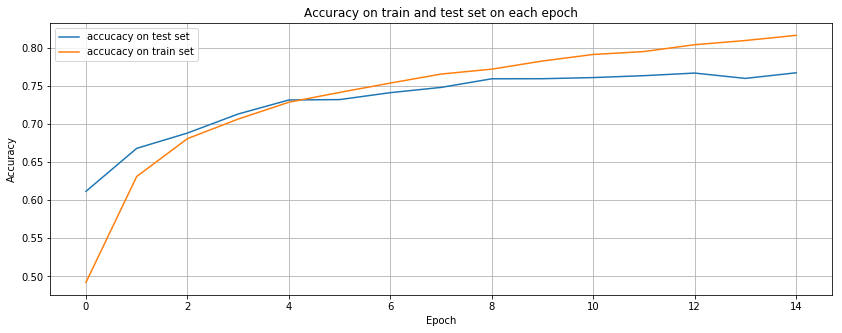

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[14, 5])
plt.plot(accuracy_history_test, label='accucacy on test set')
plt.plot(accuracy_history_train, label='accucacy on train set')
plt.legend(loc='best')
plt.title('Accuracy on train and test set on each epoch')
plt.grid('True')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [16]:
model = model.eval()

In [17]:
torch.save(model, 'CIFAR10_shufflenet_finetuned.pth')

In [18]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
print('Num params in model after compression:', count_parameters(model))

Num params in model after compression: 1263854


In [20]:
np.save("exps/test_shufflenet.npy", accuracy_history_test)
np.save("exps/train_shufflenet.npy", accuracy_history_train)